In [2]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
from tensorflow import keras

# Eğitim ve Doğrulama verilerinin hazırlanması

#### Veriseti linki: https://www.kaggle.com/datasets/vaibhao/handwritten-characters (Verisetinde 'O' harfi '0'(sıfır)'ın içine koyulmuş, Görseller taranıp 'O' harfi için ayıklandı)

In [3]:
dir = "Train/"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

In [4]:
val_dir = "Validation/"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

In [5]:
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [6]:
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [7]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

In [8]:
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

In [9]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

# Evrişimsel Sinir Ağı (CNN) modelinin hazırlanması

In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "valid", activation='swish', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='swish'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='swish'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='swish'))
model.add(Dropout(0.2))
model.add(Dense(36, activation='softmax'))

In [14]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

# Modelin eğitilmesi

In [15]:
history = model.fit(train_X,train_Y, epochs=50, batch_size=32, validation_data = (val_X, val_Y),  verbose=1)

Epoch 1/50
23476/23476 [==============================] - 460s 20ms/step - loss: 0.3259 - accuracy: 0.8887 - val_loss: 0.2618 - val_accuracy: 0.9178
Epoch 2/50
23476/23476 [==============================] - 484s 21ms/step - loss: 0.2508 - accuracy: 0.9116 - val_loss: 0.2459 - val_accuracy: 0.9242
Epoch 3/50
23476/23476 [==============================] - 477s 20ms/step - loss: 0.2405 - accuracy: 0.9152 - val_loss: 0.2462 - val_accuracy: 0.9223
Epoch 4/50
23476/23476 [==============================] - 482s 21ms/step - loss: 0.2346 - accuracy: 0.9169 - val_loss: 0.2369 - val_accuracy: 0.9228
Epoch 5/50
23476/23476 [==============================] - 479s 20ms/step - loss: 0.2316 - accuracy: 0.9177 - val_loss: 0.2318 - val_accuracy: 0.9281
Epoch 6/50
23476/23476 [==============================] - 473s 20ms/step - loss: 0.2279 - accuracy: 0.9189 - val_loss: 0.2315 - val_accuracy: 0.9302
Epoch 7/50
23476/23476 [==============================] - 468s 20ms/step - loss: 0.2258 - accuracy: 0.9198

# Modeli denemek için basit düzeyde sıralama ve görüntü işleme fonksiyonları

In [16]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    return (cnts, boundingBoxes)

In [17]:
def get_letters(img):
    LB = LabelBinarizer()
    trans = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
    trans = LB.fit_transform(trans)
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=5)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image


In [18]:
def get_word(letter):
    word = "".join(letter)
    return word

# Modelin denenmesi

1/1 [==============================] - 0s 27ms/step
MERT


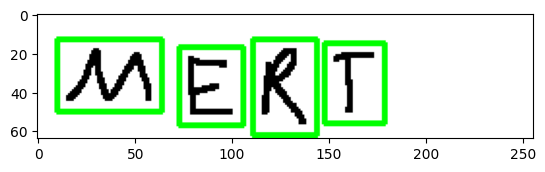

In [19]:
letter,image = get_letters("3.png")
word = get_word(letter)
print(word)
plt.imshow(image)

# Modelin kaydedilmesi

In [20]:
model.save("handwriting_recognition.h5")